In [38]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
from numpy import matmul


In [39]:
# Each element of the data dictionary is stored as an item from the data dictionary, which we
# will store in local variables, described by the following:
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.

In [40]:
plt.rcParams['figure.dpi'] = 70

In [41]:
#### 1. Data ###################################################################################

################################################################################################
# This is where you will load the data from the pickle files. For parts 1 and 2, you will use
# p1_data.pkl. For Part 3, you will use pt3_data.pkl.
################################################################################################

In [42]:
with open('data/pt3_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [43]:
################################################################################################
# Each element of the data dictionary is stored as an item from the data dictionary, which we
# will store in local variables, described by the following:
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
################################################################################################

In [44]:
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

In [45]:
gt.__dict__

{'do_diff': True,
 '_p_init': array([[ 8.34462935e-06,  9.08568545e-05, -5.00664425e+00],
        [ 7.85825614e-06,  9.12463729e-05, -5.00662613e+00],
        [ 7.38141944e-06,  9.16224817e-05, -5.00660801e+00],
        ...,
        [ 1.86048538e+02,  7.77716217e+01, -5.00547981e+00],
        [ 1.86111771e+02,  7.77564240e+01, -5.00548649e+00],
        [ 1.86174973e+02,  7.77412415e+01, -5.00549507e+00]]),
 '_r_init': array([[-4.10126808e-05, -6.78300823e-05,  1.06526437e-06],
        [-3.99474123e-05, -6.62803603e-05,  1.06526437e-06],
        [-3.88821479e-05, -6.48498500e-05,  1.06526437e-06],
        ...,
        [ 2.21818388e-05, -3.69322291e-03, -2.35822166e-01],
        [ 2.22517703e-05, -3.64327407e-03, -2.35821783e-01],
        [ 2.23312779e-05, -3.58641116e-03, -2.35821466e-01]]),
 '_v_init': array([None], dtype=object),
 '_w_init': array([None], dtype=object),
 '_a_init': array([None], dtype=object),
 '_alpha_init': array([None], dtype=object),
 '_t': array([ 2.055,  2.06 , 

In [46]:
lidar.data

array([[-1.21543380e+00, -9.50942168e-02, -4.99910491e-01],
       [ 1.51615773e-01, -3.22337937e-01,  1.98545449e-01],
       [-2.59387164e-01, -6.74227693e-01,  5.02131391e-01],
       ...,
       [ 1.88739634e+02,  6.00823985e+01,  5.59282323e+00],
       [ 1.89719938e+02,  6.04801328e+01,  5.65767381e+00],
       [ 1.91144238e+02,  5.93167056e+01,  5.82667079e+00]])

In [47]:
gt._v.shape, gt._a.shape

((8734, 3), (8734, 3))

In [48]:
imu_f.__dict__, imu_f.data.shape

({'data': array([[-0.01996148,  0.03136036,  9.78135591],
         [-0.01986699,  0.03743271,  9.79679338],
         [ 0.01269854, -0.02131687,  9.81265361],
         ...,
         [-1.32458701,  0.35196761,  9.73522034],
         [-0.47210374, -0.42987602,  9.76335312],
         [-1.31729961,  0.29819817,  9.76891354]]),
  't': array([ 2.055,  2.06 ,  2.065, ..., 56.64 , 56.645, 56.65 ])},
 (10918, 3))

In [49]:
################################################################################################
# Let's plot the ground truth trajectory to see what it looks like. When you're testing your
# code later, feel free to comment this out.
################################################################################################

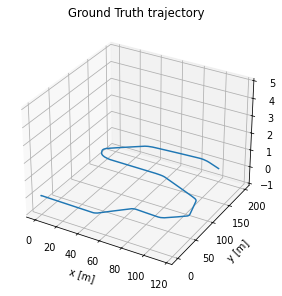

In [50]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [51]:
################################################################################################
# Remember that our LIDAR data is actually just a set of positions estimated from a separate
# scan-matching system, so we can insert it into our solver as another position measurement,
# just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the
# IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our
# known extrinsic calibration rotation matrix C_li and translation vector t_i_li.
#
# THIS IS THE CODE YOU WILL MODIFY FOR PART 2 OF THE ASSIGNMENT.
################################################################################################
# Correct calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.1).

In [52]:
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

In [53]:
# Incorrect calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.05).
# C_li = np.array([
#      [ 0.9975 , -0.04742,  0.05235],
#      [ 0.04992,  0.99763, -0.04742],
#      [-0.04998,  0.04992,  0.9975 ]
# ])


In [54]:
t_i_li = np.array([0.5, 0.1, 0.5])

In [55]:
# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

In [56]:
lidar.data

array([[-7.25929545e-01, -9.33445125e-02,  5.73395632e-02],
       [ 6.92859879e-01, -2.14174433e-01,  6.74380219e-01],
       [ 3.35226330e-01, -6.18522943e-01,  9.80182787e-01],
       ...,
       [ 1.82526392e+02,  7.83914550e+01, -3.55052408e-01],
       [ 1.83465455e+02,  7.88816509e+01, -3.19504638e-01],
       [ 1.85003213e+02,  7.78596469e+01, -2.80194945e-01]])

In [57]:
#### 2. Constants ##############################################################################

################################################################################################
# Now that our data is set up, we can start getting things ready for our solver. One of the
# most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.
################################################################################################
var_imu_f = 0.05
var_imu_w = 0.001
var_gnss  = 0.5
var_lidar = 0.2

In [58]:
################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

In [59]:
#### 3. Initial Values #########################################################################

################################################################################################
# Let's set up some initial values for our ES-EKF solver.
################################################################################################
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

In [60]:
p_est

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [61]:
# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

In [62]:
gt.p[1]

array([-4.86373210e-07,  3.89518391e-07,  1.81198120e-05])

In [63]:
#### 4. Measurement Update #####################################################################

################################################################################################
# Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make
# a function for it.
################################################################################################
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    # 3.1 Compute Kalman Gain
    r_cov = np.eye(3) * sensor_var
    k_gain = p_cov_check.dot(h_jac.T).dot(np.linalg.inv(h_jac.dot(p_cov_check).dot(h_jac.T) + r_cov))
    # 3.2 Compute error state
    x_error = k_gain.dot(y_k - p_check)
    # 3.3 Correct predicted state
    p_hat = p_check + x_error[0:3]
    v_hat = v_check + x_error[3:6]
    q_hat = Quaternion(euler=x_error[6:9]).quat_mult_left(q_check)
    # 3.4 Compute corrected covariance
    p_cov_hat = (np.eye(9) - k_gain.dot(h_jac)).dot(p_cov_check)
    return p_hat, v_hat, q_hat, p_cov_hat

In [64]:
################################################################################################
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    # print("SETP : ", k)
    delta_t = imu_f.t[k] - imu_f.t[k - 1]       # 两个数据之间的时间间隔

    # 1. Update state with IMU inputs
    q_cov = delta_t**2*np.diag([var_imu_f,var_imu_f,var_imu_f,var_imu_w,var_imu_w,var_imu_w])         # 输入（IMU）的协方差矩阵

    Cns = Quaternion(*q_est[k - 1]).to_mat()            # 四元数转旋转矩阵
    p_check = p_est[k - 1] + delta_t * v_est[k - 1] + (delta_t ** 2) * 0.5 * (matmul(Cns, imu_f.data[k - 1]) + g)
    v_check = v_est[k - 1] + delta_t * (matmul(Cns, imu_f.data[k - 1]) + g)
    q_check = Quaternion(euler=delta_t * imu_w.data[k - 1]).quat_mult_right(q_est[k - 1])
    # 1. Update state with IMU inputs
    ################ CORRECTION STEP #####################
    # 1.1 Linearize the motion model and compute Jacobians
    f_jac = np.eye(9)
    i_1 = np.eye(3)*delta_t
    f = imu_f.data[k-1].reshape((3,1))     # 3*1
    # i_2 = -skew_symmetric( np.dot(C_ns,f).reshape((3,1)) )*delta_t
    i_2 = matmul(Cns, -skew_symmetric(f)) * delta_t
    f_jac[:3,3:6] = i_1
    f_jac[3:6,6:] = i_2
    m_jac = np.eye(3)

    # 2. Propagate uncertainty
    p_cov_check = f_jac@p_cov[k-1]@f_jac.T + l_jac@q_cov@l_jac.T       # 9*9

    # 3. Check availability of GNSS and LIDAR measurements
    # 如果两个观测都不可用，那么直接使用运动模型的预测
    p_hat, v_hat, q_hat, p_cov_hat = p_check,v_check,q_check,p_cov_check
    p_est[k], v_est[k], q_est[k], p_cov[k] = p_check,v_check,q_check,p_cov_check
    for i in range(len(gnss.t)):
        if(abs(gnss.t[i]-imu_f.t[k])<0.01):
            p_hat, v_hat, q_hat, p_cov_hat = measurement_update(sensor_var=var_gnss,p_cov_check=p_cov_hat,y_k=gnss.data[i],
                                                                p_check = p_hat,v_check = v_hat,q_check = q_hat)

    for i in range(len(lidar.t)):
        if(abs(lidar.t[i]-imu_f.t[k])<0.01):
            p_hat, v_hat, q_hat, p_cov_hat = measurement_update(sensor_var=var_lidar, p_cov_check=p_cov_hat,y_k=lidar.data[i],
                                                              p_check = p_hat,v_check = v_hat,q_check = q_hat)



    p_est[k] = p_hat
    v_est[k] = v_hat
    q_est[k] = q_hat  # 4*1
    p_cov[k] = p_cov_hat

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 3) + inhomogeneous part.

In [29]:
??Quaternion

Init signature: Quaternion(w=1.0, x=0.0, y=0.0, z=0.0, axis_angle=None, euler=None)
Docstring:      <no docstring>
Source:        
class Quaternion():
    def __init__(self, w=1., x=0., y=0., z=0., axis_angle=None, euler=None):
        """
        Allow initialization with explicit quaterion wxyz, axis-angle, or Euler XYZ (RPY) angles.

        :param w: w (real) of quaternion.
        :param x: x (i) of quaternion.
        :param y: y (j) of quaternion.
        :param z: z (k) of quaternion.
        :param axis_angle: Set of three values from axis-angle representation, as list or [3,] or [3,1] np.ndarray.
                           See C2M5L2 for details.
        :param euler: Set of three XYZ Euler angles. 
        """
        if axis_angle is None and euler is None:
            self.w = w
            self.x = x
            self.y = y
            self.z = z
        elif euler is not None and axis_angle is not None:
            raise AttributeError("Only one of axis_angle or euler can

In [36]:
q = Quaternion(*q_est[0])
q_matrix = np.array(q.to_mat().tolist())
q_matrix  # Ensure q_matrix is a homogeneous 2D array


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 3) + inhomogeneous part.

In [2105]:
# ??skew_symmetric

In [ ]:
aa = np.array([[0,0], [1,0],[0,1]])
aa

In [2107]:
#### 5. Main Filter Loop #######################################################################

################################################################################################
# Now that everything is set up, we can start taking in the sensor data and creating estimates
# for our state in a loop.
################################################################################################
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # 1. Update state with IMU inputs
    C_ns = Quaternion(*q_est[k-1]).to_mat()

    C_ns_d_f_km = np.dot(C_ns, imu_f.data[k-1])

    p_est[k] = p_est[k-1] + delta_t * v_est[k-1] + (delta_t**2) / 2 * (C_ns_d_f_km + g)
    v_est[k] = v_est[k-1] + delta_t * (C_ns_d_f_km + g)
    q_fr_w = Quaternion(axis_angle=imu_w.data[k-1] * delta_t)
    q_est[k] = q_fr_w.quat_mult_right(q_est[k-1])

    # 1.1 Linearize the motion model and compute Jacobians
    f_ja_km = np.identity(9)
    f_ja_km[0:3, 3:6] = np.identity(3) * delta_t
    f_ja_km[3:6, 6:9] = -skew_symmetric(C_ns_d_f_km) * delta_t

    # 2. Propagate uncertainty
    q_cov_km = np.identity(6)
    q_cov_km[0:3,0:3] *=  delta_t**2 * np.eye(3) * var_imu_f
    q_cov_km[3:6, 3:6] *= delta_t**2 * np.eye(3) * var_imu_w
    p_cov[k] = f_ja_km.dot(p_cov[k-1]).dot(f_ja_km.T) + l_jac.dot(q_cov_km).dot(l_jac.T)
    # 3. Check availability of GNSS and LIDAR measurements
    if gnss_i < gnss.data.shape[0] and imu_f.t[k] == gnss.t[gnss_i]:
        p_est[k], v_est[k], q_est[k], p_cov[k] = \
            measurement_update(var_gnss, p_cov[k], gnss.data[gnss_i].T, p_est[k], v_est[k], q_est[k])
        gnss_i += 1

    if lidar_i < lidar.t.shape[0] and lidar.t[lidar_i] == imu_f.t[k-1]:
        p_est[k], v_est[k], q_est[k], p_cov[k] = \
            measurement_update(var_lidar, p_cov[k], lidar.data[lidar_i].T, p_est[k], v_est[k], q_est[k])
        lidar_i += 1


In [ ]:
q_check

In [ ]:
np.zeros(3)

In [ ]:
#### 6. Results and Analysis ###################################################################

################################################################################################
# Now that we have state estimates for all of our sensor data, let's plot the results. This plot
# will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating
# your estimated poses from the part of the trajectory where you don't have ground truth!
################################################################################################
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

In [ ]:
################################################################################################
# We can also plot the error for each of the 6 DOF, with estimates for our uncertainty
# included. The error estimates are in blue, and the uncertainty bounds are red and dashed.
# The uncertainty bounds are +/- 3 standard deviations based on our uncertainty (covariance).
################################################################################################
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.show()

In [2112]:
#### 7. Submission #############################################################################

################################################################################################
# Now we can prepare your results for submission to the Coursera platform. Uncomment the
# corresponding lines to prepare a file that will save your position estimates in a format
# that corresponds to what we're expecting on Coursera.
################################################################################################

# Pt. 1 submission
# p1_indices = [9000, 9400, 9800, 10200, 10600]
# p1_str = ''
# for val in p1_indices:
#     for i in range(3):
#         p1_str += '%.3f ' % (p_est[val, i])
# with open('pt1_submission.txt', 'w') as file:
#     file.write(p1_str)

# Pt. 2 submission
# p2_indices = [9000, 9400, 9800, 10200, 10600]
# p2_str = ''
# for val in p2_indices:
#     for i in range(3):
#         p2_str += '%.3f ' % (p_est[val, i])
# with open('pt2_submission.txt', 'w') as file:
#     file.write(p2_str)

# Pt. 3 submission
p3_indices = [6800, 7600, 8400, 9200, 10000]
p3_str = ''
for val in p3_indices:
    for i in range(3):
        p3_str += '%.3f ' % (p_est[val, i])
with open('pt3_submission.txt', 'w') as file:
    file.write(p3_str)